## Support Vector Classifier for emotion, based on 4 simple features

Binary classification for each emotion. Trained with k fold cross validation and a loop over multiple shufflings of the data. Accuracy around 60%. Random is 50%.

Balences data to account for imbalanced data (some emotions are not reported as often as others)


##### Observe: data poorly seperable with SVC linear classifier

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy

In [20]:
# Data import

ZC = np.load('../preprocessing/SimpleFeatures/zeroCrossings_frame200ms_hop100ms.npy')
SC = np.load('../preprocessing/SimpleFeatures/spectralCentroid_frame200ms_hop100ms.npy')
SV = np.load('../preprocessing/SimpleFeatures/spectralVariance_frame200ms_hop100ms.npy')
ST = np.load('../preprocessing/SimpleFeatures/staticTempoLibrosa.npy')

labels = pd.read_csv('../preprocessing/labels.csv')

In [21]:
# Only keep the emotion labels 
# These correspond to the average number each specific emotion was reported

# For classifying we threshold these averages at 0.5. 
# Average > 0.5: this emotion corresponds to this song
# Average < 0.5: emotion does not belong to this song

labels = labels.drop(['genre',
             'var_amazement',
             'var_solemnity',
             'var_tenderness',
             'var_nostalgia',
             'var_calmness',
             'var_power',
             'var_joyful_activation',
             'var_tension',
             'var_sadness',
             'mood',
             'var_mood',
             'liked',
             'var_liked',
             'disliked',
             'var_disliked',
             'age',
             'var_age',
             'gender',
             'var_gender',
             'number_of_observations',
             'track id'             
            ], axis=1)

emotions = list(labels)

In [22]:
np.mean(labels)

amazement            0.134012
solemnity            0.195961
tenderness           0.176911
nostalgia            0.254279
calmness             0.299257
power                0.190244
joyful_activation    0.261896
tension              0.237685
sadness              0.185288
dtype: float64

------------------------------

In [23]:
# Take the median over all frames for each song to have comparable dimensions

ZC = np.nanmedian(ZC, axis=1)
SC = np.nanmedian(SC, axis=1)
SV = np.nanmedian(SV, axis=1)

In [24]:
# OR take the mean in a certain interval

# ZC = np.mean(ZC[:, 100:200], axis=1)
# SC = np.mean(SC[:, 100:200], axis=1)
# SV = np.mean(SV[:, 2:4], axis=1)

In [25]:
# Make dataframe

features_dict_medians = {'ZC': ZC,
                         'SC': SC,
                         'SV': SV,
                         'StaticTempo': ST}
features = pd.DataFrame(data=features_dict_medians)

In [26]:
# Shuffle

def shuffleData(features, labels):
    n_data = len(features)
    idx = np.random.permutation(n_data)
    features, labels = features.reindex(idx), labels.reindex(idx)
    return features, labels

In [27]:
# K fold Crossvalidation

def kFoldConfusionMatrix(k, features, labels):

    kfold_train_metrics = []
    kfold_test_metrics = []

    confusion_Matrix_total = np.zeros((2, 2), dtype= 'int')

    # # Drop NaN values
    # NaNidx = np.where(features.isnull().any(axis=1).tolist())[0]
    # # NaNidx = np.isnan(features)[np.isnan(features) == 1].stack().index.tolist()

    # total_input = features.drop(NaNidx)
    # total_labels = labels.drop(NaNidx)

    total_input = features
    total_labels = labels

    cv = KFold(n_splits=k)

    for train_index, test_index in cv.split(total_input):        
        train_df, train_labels = total_input.iloc[train_index], total_labels.iloc[train_index]
        test_df, test_labels = total_input.iloc[test_index], total_labels.iloc[test_index]

        # Standardizing data
        mean = train_df.mean()
        std = train_df.std()

        train_df = (train_df - mean) / std
        test_df = (test_df - mean) / std

        # Classifier
        clf = svm.SVC(kernel='rbf', class_weight='balanced')
        clf.fit(train_df, train_labels)

        kfold_train_metrics.append(clf.score(train_df, train_labels))
        kfold_test_metrics.append(clf.score(test_df, test_labels))

        assert np.shape(clf.predict(test_df)) == np.shape(test_labels)
        
        CM = confusion_matrix(test_labels, clf.predict(test_df), labels= [0,1])
        
        assert np.shape(CM) == (2,2)

        confusion_Matrix_total += CM
    return confusion_Matrix_total

In [28]:
# Doing the actual training of the support vector classifier over multple rounds of shuffeling
threshold = 0.5

N_emotions = 9
N_features = 4

confusion_Matrix = np.zeros((N_emotions, 2, 2))

N_shuffles = 5
k = 10
accuracies = np.zeros((N_emotions, N_shuffles))

for e_idx, emotion in enumerate(emotions):
    for Siter in range(N_shuffles):
        thresholdedLabel = copy.deepcopy(labels[emotion])
        thresholdedLabel[thresholdedLabel >= threshold] = int(1)
        thresholdedLabel[thresholdedLabel <  threshold] = int(0)

        features, thresholdedLabel = shuffleData(features, thresholdedLabel)

        confusion_Matrix[e_idx, :, :] += kFoldConfusionMatrix(k, features, thresholdedLabel)

        accuracies[e_idx, Siter] = np.sum(np.eye(2)*confusion_Matrix[e_idx, :, :])/np.sum(confusion_Matrix[e_idx, :, :])

EMOTION amazement: 

Accuracy: 0.9039166666666667 +- 0.002068278940998481 

[[0.91183879 0.08816121]
 [1.         0.        ]]





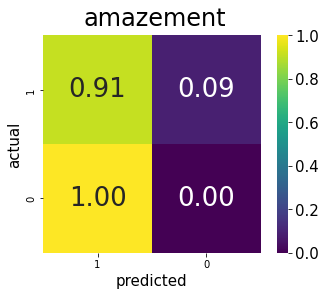

EMOTION solemnity: 

Accuracy: 0.6433916666666667 +- 0.00878641628373659 

[[0.66246719 0.33753281]
 [0.53684211 0.46315789]]





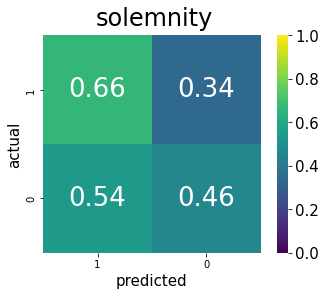

EMOTION tenderness: 

Accuracy: 0.5576500000000001 +- 0.006564297372910519 

[[0.56568365 0.43431635]
 [0.48888889 0.51111111]]





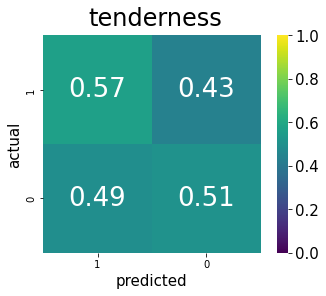

EMOTION nostalgia: 

Accuracy: 0.4714666666666667 +- 0.006650522118183234 

[[0.4740113  0.5259887 ]
 [0.46086957 0.53913043]]





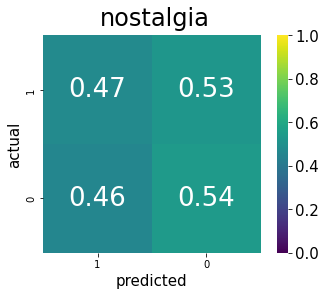

EMOTION calmness: 

Accuracy: 0.4343 +- 0.0047916594202843795 

[[0.33376206 0.66623794]
 [0.23820225 0.76179775]]





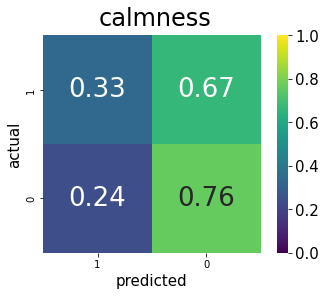

EMOTION power: 

Accuracy: 0.732925 +- 0.003067572330035566 

[[0.7557377 0.2442623]
 [0.5       0.5      ]]





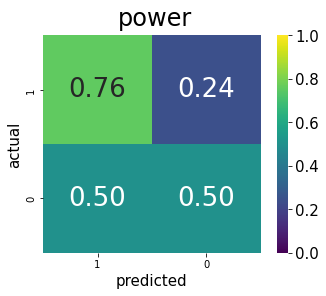

EMOTION joyful_activation: 

Accuracy: 0.6119916666666667 +- 0.009920111446506598 

[[0.6681388  0.3318612 ]
 [0.57108434 0.42891566]]





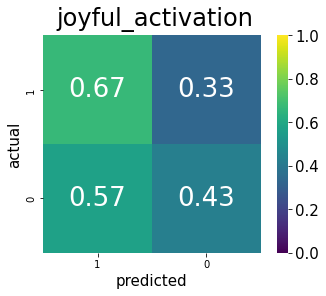

EMOTION tension: 

Accuracy: 0.6653249999999999 +- 0.014123915887599979 

[[0.68788732 0.31211268]
 [0.64       0.36      ]]





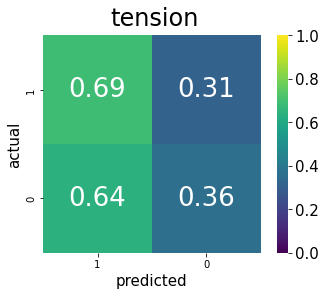

EMOTION sadness: 

Accuracy: 0.5341583333333333 +- 0.01124260250614205 

[[0.54881266 0.45118734]
 [0.6        0.4       ]]





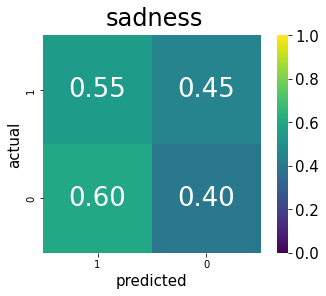

In [60]:
import seaborn as sns

for e_idx, emotion in enumerate(emotions):
    print(f'EMOTION {emotion}: \n')
    print(f'Accuracy: {np.mean(accuracies[e_idx, :])} +- {np.std(accuracies[e_idx, :])} \n')

    CMATRIX = confusion_Matrix[e_idx, :, :] 
    CMATRIX = CMATRIX / np.sum(CMATRIX, axis=1)[:, np.newaxis]
    print(CMATRIX)
    print('\n\n')

    fig,ax = plt.subplots()
    fig.suptitle(f'{emotion}', size=24)
    
    F = sns.heatmap(CMATRIX, annot=True, annot_kws={"fontsize":26}, fmt='.2f', xticklabels=['1', '0'], yticklabels = ['1', '0'], vmin=0, vmax=1, cmap='viridis')
    plt.ylabel('actual', size=15)
    plt.xlabel('predicted', size=15)
    plt.gca().set_aspect('equal')
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)

    plt.show()

    fig.savefig(f'emotion_confusion_matrix_RBF_{emotion}.png', bbox_inches="tight")
